In [1]:
from lib.NeuralNet import *
from lib.Optimizer import Adam,SGD,AdaGrad,RMSProp,Yogi

| TIME:     0.20s | EPOCH:     1 | LOSS: 0.10029134 |
| TIME:    11.00s | EPOCH:   100 | LOSS: 0.02701976 |
| TIME:    21.74s | EPOCH:   200 | LOSS: 0.01249189 |
| TIME:    32.38s | EPOCH:   300 | LOSS: 0.00636812 |
| TIME:    43.30s | EPOCH:   400 | LOSS: 0.00529672 |
| TIME:    54.24s | EPOCH:   500 | LOSS: 0.00444705 |
| TIME:    65.00s | EPOCH:   600 | LOSS: 0.00328238 |
| TIME:    75.80s | EPOCH:   700 | LOSS: 0.00311709 |
| TIME:    85.92s | EPOCH:   800 | LOSS: 0.00277294 |
| TIME:    96.83s | EPOCH:   900 | LOSS: 0.00207640 |
| TIME:   107.71s | EPOCH:  1000 | LOSS: 0.00194689 |


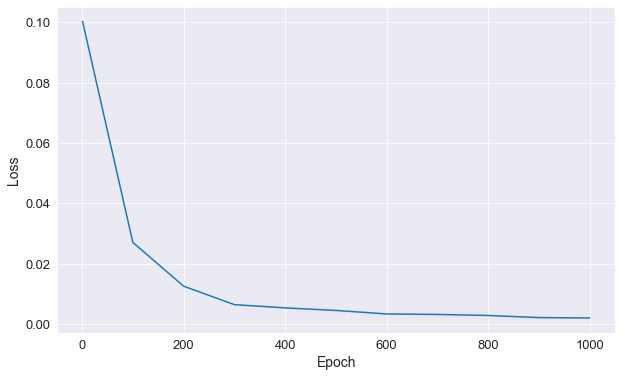

In [2]:
X = np.random.rand(5000,100)
y = np.random.rand(5000,1)
W1,b1,W2,b2,W3,b3 = FitModel(X,y,n_iter=1000,batch_size=500,lr=1e-3,update=Yogi,print_every_epochs=100,print_graph=True)